In [1]:
!git clone https://github.com/Sabrina2701/PokemonChallenge-FDS.git

Cloning into 'PokemonChallenge-FDS'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 73 (delta 19), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 164.62 KiB | 7.48 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [2]:
import sys

repo_path = '/kaggle/working/PokemonChallenge-FDS'
if repo_path not in sys.path:
    sys.path.append(repo_path)

In this section, we implemented the predictive model using an ensemble learning technique, specifically Stacking. The chosen base models are Logistic Regression, Random Forest, and KNN. The hyperparameters of each base model were tuned using RandomizedSearchCV, which performed 10 iterations for each model and in each iteration executed 10-fold cross-validation, sampling parameters from a distribution defined by us. For the meta-model, we adopted a Logistic Regression model, which was tuned using RandomizedSearchCV with 10 iterations and 5-fold cross-validation. Subsequently, the meta-model was evaluated and the submission file was generated. The metric used to chose the best models is neg_log_loss.

Initializing Setup(loading and processing data)
Base CV strategy: 10-Fold StratifiedKFold
Meta CV strategy: 5-Fold StratifiedKFold
Data Loading...
Caricamento dati da '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.
Caricamento dati da '../input/fds-pokemon-battles-prediction-2025/test.jsonl'...
Successfully loaded 5000 battles.
Data Loading completed.
Feature Engineering (with pruned features)...


Extracting features: 100%|██████████| 5000/5000 [00:04<00:00, 1167.01it/s]


Feature Engineering completed.
Data preparation for model training...

Data preparation completed:
  Training features (X_prescale): (10000, 54)
Displaying DataFrame head:
    p1_avg_hp  p1_avg_atk  p1_avg_def  p1_avg_spe  p1_avg_special  \
0  115.833333   72.500000   63.333333   80.000000      100.000000   
1  123.333333   72.500000   65.833333   61.666667       90.000000   
2  124.166667   84.166667   71.666667   65.833333       90.000000   
3  121.666667   77.500000   65.833333   75.833333      103.333333   
4  114.166667   75.833333   79.166667   72.500000       97.500000   

   p1_avg_crit_rate  p1_high_crit_threats  p1_threat_score  p1_score_vs_ice  \
0          0.156250                   3.0                4                0   
1          0.120443                   1.0               -2                1   
2          0.128581                   2.0                3               -2   
3          0.148112                   3.0                3               -2   
4          0.14160

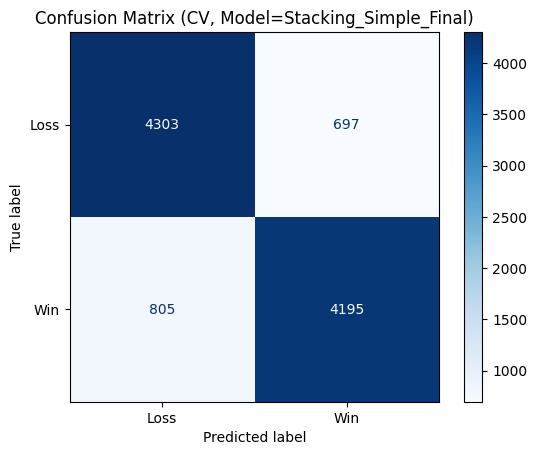


ROC Analysis for Stacking_Simple_Final

--- ROC Curve and Optimal Threshold Analysis ---
Area Under the Curve (AUC): 0.9218

'Optimal' threshold found (closest to 0,1): 0.4971
ROC Curve saved as 'roc_curve_winner.png'


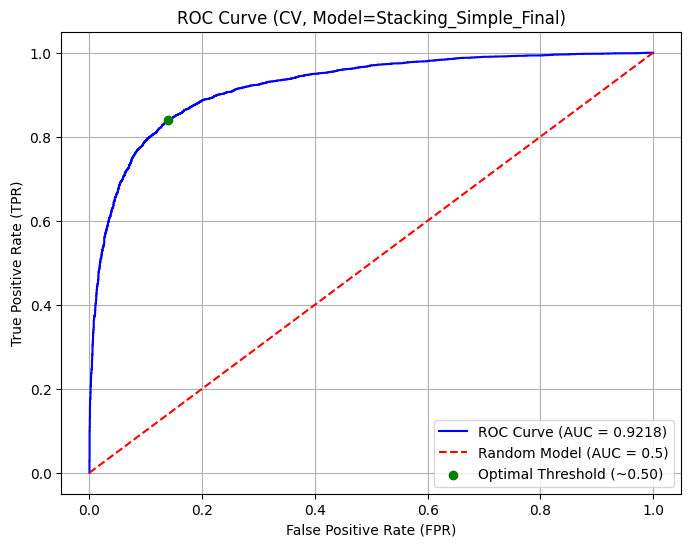


--- Threshold Performance Comparison ---
Accuracy @ 0.5 Threshold (Default): 0.8498
Accuracy @ Optimal Threshold (0.4971):   0.8501

--- Classification Report with OPTIMAL THRESHOLD ---
              precision    recall  f1-score   support

    Loss (0)       0.84      0.86      0.85      5000
     Win (1)       0.86      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Generating submission file

 Generating Submission
Using Winning Model: Stacking_Simple_Final
Using Optimal Threshold: 0.4971

submission1.csv file created successfully!
Submission file head:
   battle_id  player_won
0          0           0
1          1           1
2          2           1
3          3           1
4          4           1

Full Process Completed


In [3]:
import pandas as pd
import numpy as np
from typing import Dict, List
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, 
    train_test_split, cross_val_predict, cross_val_score
)
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from config import Config
from feature_creations import create_features, load_data
from stacker_builder import StackingModelBuilder
from model_tuner import BaseModelTuner
from evaluations import evaluate_model_performance, find_optimal_threshold, create_submission_file
from rf_model import RandomForestModel
from lr_model import LogisticRegressionModel
from knn_model import KNNModel
from gboost_model import GradientBoostingModel
import warnings
import sys




def display(df):
    print("Displaying DataFrame head:")
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
        print(df.head())


def main():
    
    print("Initializing Setup(loading and processing data)")
    
    cv_base_strategy = StratifiedKFold(
        n_splits=Config.CV_SPLITS_BASE,
        shuffle=True, 
        random_state=Config.RANDOM_STATE
    )
    print(f"Base CV strategy: {Config.CV_SPLITS_BASE}-Fold StratifiedKFold")
    
    cv_meta_strategy = StratifiedKFold(
        n_splits=Config.CV_SPLITS_META,
        shuffle=True, 
        random_state=Config.RANDOM_STATE
    )
    print(f"Meta CV strategy: {Config.CV_SPLITS_META}-Fold StratifiedKFold")

    print("Data Loading...")
    train_data_raw = load_data(Config.TRAIN_FILE)
    test_data_raw = load_data(Config.TEST_FILE)
    print("Data Loading completed.")

    print("Feature Engineering (with pruned features)...")
    train_df = create_features(train_data_raw) 
    test_df = create_features(test_data_raw)
    print("Feature Engineering completed.")

    print("Data preparation for model training...")
    try:
        features = [col for col in train_df.columns if col not in [Config.ID_COLUMN_NAME, Config.TARGET_COLUMN_NAME]]
        X_prescale = train_df[features]
        y = train_df[Config.TARGET_COLUMN_NAME]
        X_test_prescale = test_df[features] 
    except KeyError as e:
        print(f"Error: Missing expected column. {e}", file=sys.stderr)
        return
    
    print("\nData preparation completed:")
    print(f"  Training features (X_prescale): {X_prescale.shape}")
    display(X_prescale.head())


    print("\nDefining Base Models")
    models_to_tune = [
        LogisticRegressionModel(random_state=Config.RANDOM_STATE, max_iter=Config.MAX_ITER),
        RandomForestModel(random_state=Config.RANDOM_STATE),
        KNNModel(random_state=Config.RANDOM_STATE)
    ]
    print(f"Models to tune: {[m.get_name() for m in models_to_tune]}")


    print("Starting Base Model Tuning (RandomizedSearch)")

    tuner = BaseModelTuner(X_prescale, y, cv_base_strategy, models_to_tune)
    
    results_list, best_params_dict = tuner.tune_models('neg_log_loss')
    results_df = pd.DataFrame(results_list)
    

    
    print("\nBuilding Stacking Model")
    stack_builder = StackingModelBuilder(
        model_list=models_to_tune,
        base_model_params=best_params_dict,
        cv_strategy=cv_meta_strategy 
    )
    final_stacking_pipeline = stack_builder.get_pipeline() #this is the stackingclassifier
    final_stacking_distributions = stack_builder.get_param_grid() 
    print("Stacking pipeline and parameter grid created.")


    final_search = RandomizedSearchCV(
        estimator=final_stacking_pipeline,
        param_distributions=final_stacking_distributions,
        n_iter=Config.RANDOM_SEARCH_ITER_META,
        cv=cv_meta_strategy, 
        scoring=['accuracy', 'roc_auc', 'neg_log_loss'],
        refit='neg_log_loss',
        n_jobs=-1,
        verbose=1,
        random_state=Config.RANDOM_STATE
    )
    final_search.fit(X_prescale, y)
    print("Stacking Tuning Completed")
    
    model_final = final_search.best_estimator_
    print(f"Best Meta-Params: {final_search.best_params_}")
    print(f"Best CV neg_log_loss Score: {final_search.best_score_:.4f}")
    tuned_params_display = {'model': 'Stacking_Simple_Final'}
    tuned_params_display.update(final_search.best_params_)


    
    #CV Evaluation & Score Check
    print(f"\nGenerating Final CV Predictions for {tuned_params_display['model']}")
    
    print("Running cross_val_predict to get probabilities...")
    y_proba_cv = cross_val_predict(
        model_final, 
        X_prescale, 
        y, 
        cv=cv_meta_strategy, # Use 5-fold CV
        method='predict_proba',
        n_jobs=-1
    )
    
    print("Running cross_val_score to get accuracy stability...")
    scores_tuned = cross_val_score(
        model_final, X_prescale, y, cv=cv_meta_strategy, scoring='accuracy'
    )
    print(f"Mean CV Accuracy: {np.mean(scores_tuned):.4f} +/- {np.std(scores_tuned):.4f}")

    y_proba_cv_positive = y_proba_cv[:, 1]
    y_pred_cv_default = (y_proba_cv_positive >= 0.5).astype(int)
    print("CV predictions generated.")

    
    #Classification Report
    print(f"\nClassification Report for {tuned_params_display['model']}")
    evaluate_model_performance(
        y, # y_true
        y_pred_cv_default, # y_pred
        tuned_params_display
    )

    #ROC Analysis 
    print(f"\nROC Analysis for {tuned_params_display['model']}")
    optimal_threshold = find_optimal_threshold(
        y, # y_true
        y_proba_cv_positive, # probabilities
        y_pred_cv_default, 
        tuned_params_display
    )

    #Submission File Generation
    print("\nGenerating submission file")
    create_submission_file(
        model_final, 
        X_test_prescale, 
        test_df, 
        optimal_threshold, 
        tuned_params_display,
        'submission1.csv'
    )

    print("\nFull Process Completed")


if __name__ == "__main__":
    main()

In this section, we implemented the predictive model using an ensemble learning technique, specifically Stacking. The chosen base models are Logistic Regression, Random Forest, and GradientBoosting. As for the rest of the code it is more or less the same as the previous implementation.

Initializing Setup(loading and processing data)
Base CV strategy: 10-Fold StratifiedKFold
Meta CV strategy: 5-Fold StratifiedKFold
Data Loading...
Caricamento dati da '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.
Caricamento dati da '../input/fds-pokemon-battles-prediction-2025/test.jsonl'...
Successfully loaded 5000 battles.
Data Loading completed.
Feature Engineering (with pruned features)...


Extracting features: 100%|██████████| 5000/5000 [00:04<00:00, 1184.71it/s]


Feature Engineering completed.
Data preparation for model training...

Data preparation completed:
  Training features (X_prescale): (10000, 54)
Displaying DataFrame head:
    p1_avg_hp  p1_avg_atk  p1_avg_def  p1_avg_spe  p1_avg_special  \
0  115.833333   72.500000   63.333333   80.000000      100.000000   
1  123.333333   72.500000   65.833333   61.666667       90.000000   
2  124.166667   84.166667   71.666667   65.833333       90.000000   
3  121.666667   77.500000   65.833333   75.833333      103.333333   
4  114.166667   75.833333   79.166667   72.500000       97.500000   

   p1_avg_crit_rate  p1_high_crit_threats  p1_threat_score  p1_score_vs_ice  \
0          0.156250                   3.0                4                0   
1          0.120443                   1.0               -2                1   
2          0.128581                   2.0                3               -2   
3          0.148112                   3.0                3               -2   
4          0.14160

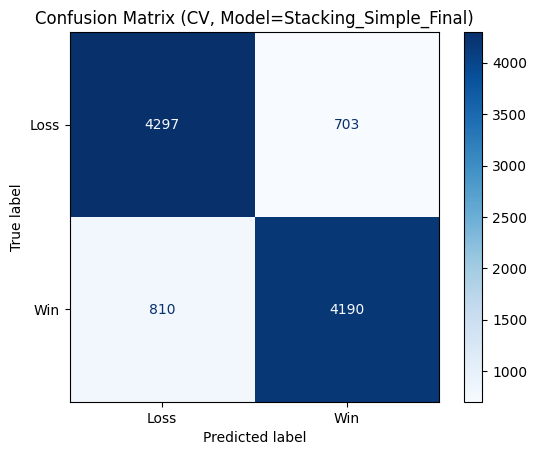


ROC Analysis for Stacking_Simple_Final

--- ROC Curve and Optimal Threshold Analysis ---
Area Under the Curve (AUC): 0.9217

'Optimal' threshold found (closest to 0,1): 0.5092
ROC Curve saved as 'roc_curve_winner.png'


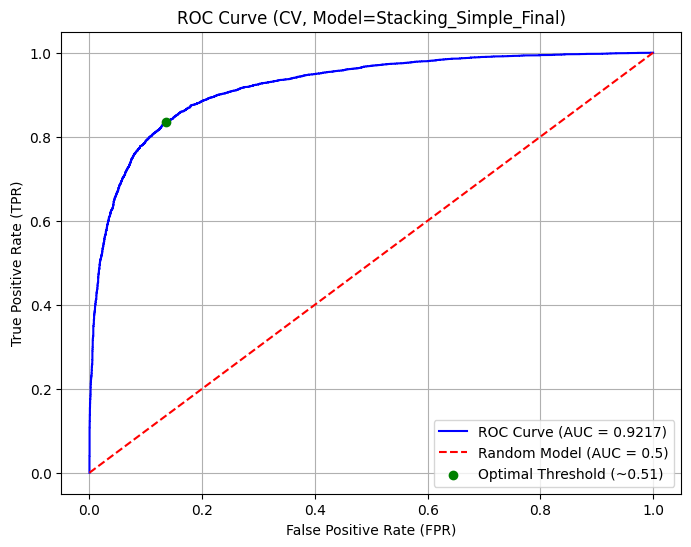


--- Threshold Performance Comparison ---
Accuracy @ 0.5 Threshold (Default): 0.8487
Accuracy @ Optimal Threshold (0.5092):   0.8498

--- Classification Report with OPTIMAL THRESHOLD ---
              precision    recall  f1-score   support

    Loss (0)       0.84      0.86      0.85      5000
     Win (1)       0.86      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Generating submission file

 Generating Submission
Using Winning Model: Stacking_Simple_Final
Using Optimal Threshold: 0.5092

submission2.csv file created successfully!
Submission file head:
   battle_id  player_won
0          0           0
1          1           1
2          2           1
3          3           1
4          4           1

Full Process Completed


In [4]:
import pandas as pd
import numpy as np
from typing import Dict, List
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, 
    train_test_split, cross_val_predict, cross_val_score
)
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from config import Config
from feature_creations import create_features, load_data
from stacker_builder import StackingModelBuilder
from model_tuner import BaseModelTuner
from evaluations import evaluate_model_performance, find_optimal_threshold, create_submission_file
from rf_model import RandomForestModel
from lr_model import LogisticRegressionModel
from knn_model import KNNModel
from gboost_model import GradientBoostingModel
import warnings
import sys




def display(df):
    print("Displaying DataFrame head:")
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
        print(df.head())


def main():
    
    print("Initializing Setup(loading and processing data)")
    
    cv_base_strategy = StratifiedKFold(
        n_splits=Config.CV_SPLITS_BASE,
        shuffle=True, 
        random_state=Config.RANDOM_STATE
    )
    print(f"Base CV strategy: {Config.CV_SPLITS_BASE}-Fold StratifiedKFold")
    
    cv_meta_strategy = StratifiedKFold(
        n_splits=Config.CV_SPLITS_META,
        shuffle=True, 
        random_state=Config.RANDOM_STATE
    )
    print(f"Meta CV strategy: {Config.CV_SPLITS_META}-Fold StratifiedKFold")

    print("Data Loading...")
    train_data_raw = load_data(Config.TRAIN_FILE)
    test_data_raw = load_data(Config.TEST_FILE)
    print("Data Loading completed.")

    print("Feature Engineering (with pruned features)...")
    train_df = create_features(train_data_raw) 
    test_df = create_features(test_data_raw)
    print("Feature Engineering completed.")

    print("Data preparation for model training...")
    try:
        features = [col for col in train_df.columns if col not in [Config.ID_COLUMN_NAME, Config.TARGET_COLUMN_NAME]]
        X_prescale = train_df[features]
        y = train_df[Config.TARGET_COLUMN_NAME]
        X_test_prescale = test_df[features] 
    except KeyError as e:
        print(f"Error: Missing expected column. {e}", file=sys.stderr)
        return
    
    print("\nData preparation completed:")
    print(f"  Training features (X_prescale): {X_prescale.shape}")
    display(X_prescale.head())


    print("\nDefining Base Models")
    models_to_tune = [
        LogisticRegressionModel(random_state=Config.RANDOM_STATE, max_iter=Config.MAX_ITER),
        RandomForestModel(random_state=Config.RANDOM_STATE),
        GradientBoostingModel(random_state = Config.RANDOM_STATE)
    ]
    print(f"Models to tune: {[m.get_name() for m in models_to_tune]}")


    print("Starting Base Model Tuning (RandomizedSearch)")

    tuner = BaseModelTuner(X_prescale, y, cv_base_strategy, models_to_tune)
    
    results_list, best_params_dict = tuner.tune_models('neg_log_loss')
    results_df = pd.DataFrame(results_list)
    
    
    print("\nBuilding Stacking Model")
    stack_builder = StackingModelBuilder(
        model_list=models_to_tune,
        base_model_params=best_params_dict,
        cv_strategy=cv_meta_strategy 
    )
    final_stacking_pipeline = stack_builder.get_pipeline() #this is the stackingclassifier
    final_stacking_distributions = stack_builder.get_param_grid() 
    print("Stacking pipeline and parameter grid created.")


    final_search = RandomizedSearchCV(
        estimator=final_stacking_pipeline,
        param_distributions=final_stacking_distributions,
        n_iter=Config.RANDOM_SEARCH_ITER_META,
        cv=cv_meta_strategy, 
        scoring=['accuracy', 'roc_auc', 'neg_log_loss'],
        refit='neg_log_loss',
        n_jobs=-1,
        verbose=1,
        random_state=Config.RANDOM_STATE
    )
    final_search.fit(X_prescale, y)
    print("Stacking Tuning Completed")
    
    model_final = final_search.best_estimator_
    print(f"Best Meta-Params: {final_search.best_params_}")
    print(f"Best CV neg_log_loss Score: {final_search.best_score_:.4f}")
    tuned_params_display = {'model': 'Stacking_Simple_Final'}
    tuned_params_display.update(final_search.best_params_)


    
    #CV Evaluation & Score Check
    print(f"\nGenerating Final CV Predictions for {tuned_params_display['model']}")
    
    print("Running cross_val_predict to get probabilities...")
    y_proba_cv = cross_val_predict(
        model_final, 
        X_prescale, 
        y, 
        cv=cv_meta_strategy, # Use 5-fold CV
        method='predict_proba',
        n_jobs=-1
    )
    
    print("Running cross_val_score to get accuracy stability...")
    scores_tuned = cross_val_score(
        model_final, X_prescale, y, cv=cv_meta_strategy, scoring='accuracy'
    )
    print(f"Mean CV Accuracy: {np.mean(scores_tuned):.4f} +/- {np.std(scores_tuned):.4f}")

    y_proba_cv_positive = y_proba_cv[:, 1]
    y_pred_cv_default = (y_proba_cv_positive >= 0.5).astype(int)
    print("CV predictions generated.")

    
    #Classification Report
    print(f"\nClassification Report for {tuned_params_display['model']}")
    evaluate_model_performance(
        y, # y_true
        y_pred_cv_default, # y_pred
        tuned_params_display
    )

    #ROC Analysis 
    print(f"\nROC Analysis for {tuned_params_display['model']}")
    optimal_threshold = find_optimal_threshold(
        y, # y_true
        y_proba_cv_positive, # probabilities
        y_pred_cv_default, 
        tuned_params_display
    )

    #Submission File Generation
    print("\nGenerating submission file")
    create_submission_file(
        model_final, 
        X_test_prescale, 
        test_df, 
        optimal_threshold, 
        tuned_params_display,
        'submission2.csv'
    )

    print("\nFull Process Completed")


if __name__ == "__main__":
    main()

In this section, we implemented the predictive model using an ensemble learning technique, specifically Stacking. The chosen base models are Logistic Regression, Random Forest. As for the rest of the code it is more or less the same as the previous implementation.
This implementation produced the best results in the leaderboard.

Initializing Setup(loading and processing data)
Base CV strategy: 10-Fold StratifiedKFold
Meta CV strategy: 5-Fold StratifiedKFold
Data Loading...
Caricamento dati da '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.
Caricamento dati da '../input/fds-pokemon-battles-prediction-2025/test.jsonl'...
Successfully loaded 5000 battles.
Data Loading completed.
Feature Engineering (with pruned features)...


Extracting features: 100%|██████████| 5000/5000 [00:04<00:00, 1180.61it/s]


Feature Engineering completed.
Data preparation for model training...

Data preparation completed:
  Training features (X_prescale): (10000, 54)
Displaying DataFrame head:
    p1_avg_hp  p1_avg_atk  p1_avg_def  p1_avg_spe  p1_avg_special  \
0  115.833333   72.500000   63.333333   80.000000      100.000000   
1  123.333333   72.500000   65.833333   61.666667       90.000000   
2  124.166667   84.166667   71.666667   65.833333       90.000000   
3  121.666667   77.500000   65.833333   75.833333      103.333333   
4  114.166667   75.833333   79.166667   72.500000       97.500000   

   p1_avg_crit_rate  p1_high_crit_threats  p1_threat_score  p1_score_vs_ice  \
0          0.156250                   3.0                4                0   
1          0.120443                   1.0               -2                1   
2          0.128581                   2.0                3               -2   
3          0.148112                   3.0                3               -2   
4          0.14160

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Stacking Tuning Completed
Best Meta-Params: {'final_estimator__model_meta__C': 2.481040974867813, 'final_estimator__model_meta__penalty': 'l1'}
Best CV neg_log_loss Score: -0.3616

Generating Final CV Predictions for Stacking_Simple_Final
Running cross_val_predict to get probabilities...
Running cross_val_score to get accuracy stability...
Mean CV Accuracy: 0.8491 +/- 0.0041
CV predictions generated.

Classification Report for Stacking_Simple_Final

--- Classification Report (Threshold 0.5) ---
              precision    recall  f1-score   support

    Loss (0)       0.84      0.86      0.85      5000
     Win (1)       0.86      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


--- Confusion Matrix (Threshold 0.5) ---
Confusion Matrix saved as 'confusion_matrix_winner.png'


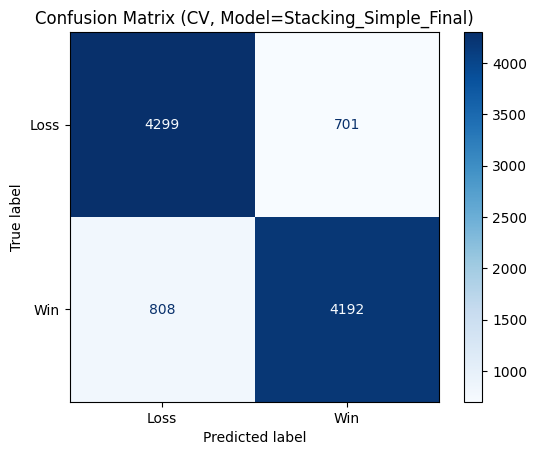


ROC Analysis for Stacking_Simple_Final

--- ROC Curve and Optimal Threshold Analysis ---
Area Under the Curve (AUC): 0.9219

'Optimal' threshold found (closest to 0,1): 0.4911
ROC Curve saved as 'roc_curve_winner.png'


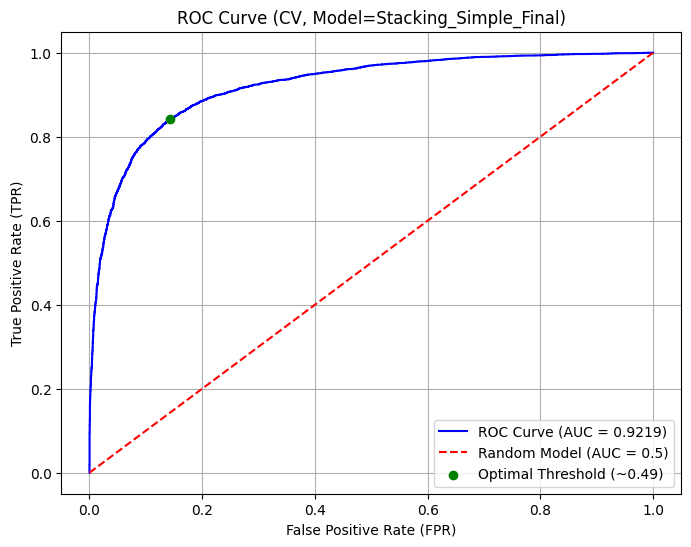


--- Threshold Performance Comparison ---
Accuracy @ 0.5 Threshold (Default): 0.8491
Accuracy @ Optimal Threshold (0.4911):   0.8494

--- Classification Report with OPTIMAL THRESHOLD ---
              precision    recall  f1-score   support

    Loss (0)       0.84      0.86      0.85      5000
     Win (1)       0.86      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Generating submission file

 Generating Submission
Using Winning Model: Stacking_Simple_Final
Using Optimal Threshold: 0.4911

submission.csv file created successfully!
Submission file head:
   battle_id  player_won
0          0           0
1          1           1
2          2           1
3          3           1
4          4           1

Full Process Completed


In [5]:
import pandas as pd
import numpy as np
from typing import Dict, List
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, 
    train_test_split, cross_val_predict, cross_val_score
)
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from config import Config
from feature_creations import create_features, load_data
from stacker_builder import StackingModelBuilder
from model_tuner import BaseModelTuner
from evaluations import evaluate_model_performance, find_optimal_threshold, create_submission_file
from rf_model import RandomForestModel
from lr_model import LogisticRegressionModel
from knn_model import KNNModel
from gboost_model import GradientBoostingModel
import warnings
import sys




def display(df):
    print("Displaying DataFrame head:")
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
        print(df.head())


def main():
    
    print("Initializing Setup(loading and processing data)")
    
    cv_base_strategy = StratifiedKFold(
        n_splits=Config.CV_SPLITS_BASE,
        shuffle=True, 
        random_state=Config.RANDOM_STATE
    )
    print(f"Base CV strategy: {Config.CV_SPLITS_BASE}-Fold StratifiedKFold")
    
    cv_meta_strategy = StratifiedKFold(
        n_splits=Config.CV_SPLITS_META,
        shuffle=True, 
        random_state=Config.RANDOM_STATE
    )
    print(f"Meta CV strategy: {Config.CV_SPLITS_META}-Fold StratifiedKFold")

    print("Data Loading...")
    train_data_raw = load_data(Config.TRAIN_FILE)
    test_data_raw = load_data(Config.TEST_FILE)
    print("Data Loading completed.")

    print("Feature Engineering (with pruned features)...")
    train_df = create_features(train_data_raw) 
    test_df = create_features(test_data_raw)
    print("Feature Engineering completed.")

    print("Data preparation for model training...")
    try:
        features = [col for col in train_df.columns if col not in [Config.ID_COLUMN_NAME, Config.TARGET_COLUMN_NAME]]
        X_prescale = train_df[features]
        y = train_df[Config.TARGET_COLUMN_NAME]
        X_test_prescale = test_df[features] 
    except KeyError as e:
        print(f"Error: Missing expected column. {e}", file=sys.stderr)
        return
    
    print("\nData preparation completed:")
    print(f"  Training features (X_prescale): {X_prescale.shape}")
    display(X_prescale.head())


    print("\nDefining Base Models")
    models_to_tune = [
        LogisticRegressionModel(random_state=Config.RANDOM_STATE, max_iter=Config.MAX_ITER),
        RandomForestModel(random_state=Config.RANDOM_STATE)
    ]
    print(f"Models to tune: {[m.get_name() for m in models_to_tune]}")


    print("Starting Base Model Tuning (RandomizedSearch)")

    tuner = BaseModelTuner(X_prescale, y, cv_base_strategy, models_to_tune)
    
    results_list, best_params_dict = tuner.tune_models('neg_log_loss')
    results_df = pd.DataFrame(results_list)
    

    
    print("\nBuilding Stacking Model")
    stack_builder = StackingModelBuilder(
        model_list=models_to_tune,
        base_model_params=best_params_dict,
        cv_strategy=cv_meta_strategy 
    )
    final_stacking_pipeline = stack_builder.get_pipeline() #this is the stackingclassifier
    final_stacking_distributions = stack_builder.get_param_grid() 
    print("Stacking pipeline and parameter grid created.")


    final_search = RandomizedSearchCV(
        estimator=final_stacking_pipeline,
        param_distributions=final_stacking_distributions,
        n_iter=Config.RANDOM_SEARCH_ITER_META,
        cv=cv_meta_strategy, 
        scoring=['accuracy', 'roc_auc', 'neg_log_loss'],
        refit='neg_log_loss',
        n_jobs=-1,
        verbose=1,
        random_state=Config.RANDOM_STATE
    )
    final_search.fit(X_prescale, y)
    print("Stacking Tuning Completed")
    
    model_final = final_search.best_estimator_
    print(f"Best Meta-Params: {final_search.best_params_}")
    print(f"Best CV neg_log_loss Score: {final_search.best_score_:.4f}")
    tuned_params_display = {'model': 'Stacking_Simple_Final'}
    tuned_params_display.update(final_search.best_params_)


    
    #CV Evaluation & Score Check
    print(f"\nGenerating Final CV Predictions for {tuned_params_display['model']}")
    
    print("Running cross_val_predict to get probabilities...")
    y_proba_cv = cross_val_predict(
        model_final, 
        X_prescale, 
        y, 
        cv=cv_meta_strategy, # Use 5-fold CV
        method='predict_proba',
        n_jobs=-1
    )
    
    print("Running cross_val_score to get accuracy stability...")
    scores_tuned = cross_val_score(
        model_final, X_prescale, y, cv=cv_meta_strategy, scoring='accuracy'
    )
    print(f"Mean CV Accuracy: {np.mean(scores_tuned):.4f} +/- {np.std(scores_tuned):.4f}")

    y_proba_cv_positive = y_proba_cv[:, 1]
    y_pred_cv_default = (y_proba_cv_positive >= 0.5).astype(int)
    print("CV predictions generated.")

    
    #Classification Report
    print(f"\nClassification Report for {tuned_params_display['model']}")
    evaluate_model_performance(
        y, # y_true
        y_pred_cv_default, # y_pred
        tuned_params_display
    )

    #ROC Analysis 
    print(f"\nROC Analysis for {tuned_params_display['model']}")
    optimal_threshold = find_optimal_threshold(
        y, # y_true
        y_proba_cv_positive, # probabilities
        y_pred_cv_default, 
        tuned_params_display
    )

    #Submission File Generation
    print("\nGenerating submission file")
    create_submission_file(
        model_final, 
        X_test_prescale, 
        test_df, 
        optimal_threshold, 
        tuned_params_display,
        'submission.csv'
    )

    print("\nFull Process Completed")


if __name__ == "__main__":
    main()